# Three-wave-mixing differentiation of chiral molecules

Use 1,2-propanediol molecular data and field configuration from ["Enantiomer-specific detection of chiral molecules via microwave spectroscopy", David Patterson, Melanie Schnell, John M. Doyle, Nature 497, 475–477 (2013)](https://www.nature.com/articles/nature12150)

Following figure demonstrates the principle:

<img src="../etc/Figure_three_wave_mixing.png" alt="three-wave" width="500"/>

Apply a sequence of microwave fields as follows:

- Initially, apply a field polarized along the laboratory's $Z$-axis to couple the ground rotational state with the state $J_{k_a, k_c} = 1_{1,0}$.
  The duration of this field is adjusted to produce a 50/50 coherent mixture of these two states.
- Next, apply a field polarized along the laboratory's $X$ (or $Y$) axis. This field couples the state $1_{1,0}$ with the state $1_{1,1}$,
  with its duration set to enable a complete population transfer from the second to the third state.
  This process results in a coherent 50/50 mixture of the ground state and the third state.
- The subsequent time evolution of the free-induction decay from the third state back to the ground state is anticipated to exhibit
  antiphase characteristics for different enantiomers, i.e., R-1,2-propanediol and S-1,2-propanediol.
  This phenomenon can be modeled by calculating the time evolution of the $Y$ (or $X$) component of the dipole moment
  following the application of the above two-pulse sequence.

In [1]:
from field_free import field_free
from stark import dipole_me_matrix, field_free_matrix
from tdse import propagate
from constants import DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS

import numpy as np
import matplotlib.pyplot as plt

### Molecular data

In [2]:
# rotational constants of 1,2-propanediol in MHz
rot_a = 8572.05
rot_b = 3640.10
rot_c = 2790.96

# molecular dipole moments for R and S enantiomers of 1,2-propanediol
dipole_debye_R = (1.2, 1.9, 0.36)
dipole_debye_S = (1.2, 1.9, -0.36)

### Field-free rotational energies and wavefunctions

Compute rotational energies for angular momentum quantum number $J=0..1$.

In [3]:
max_j = 1

rot_enr = {}
rot_vec = {}
rot_assignment = {}
rot_func_on_grid = {}

for j in range(max_j + 1):
    rot_enr[j], rot_vec[j], rot_assignment[j], grid, rot_func_on_grid[j] = field_free(
        j, rot_a, rot_b, rot_c
    )

Print rotational energies and assignments

In [4]:
print("Rotational energies\n# (J, ka, kc)  E (MHz)")
for j in rot_enr.keys():
    for i, (e, (j, ka, kc)) in enumerate(zip(rot_enr[j], rot_assignment[j])):
        print(i, (j, ka, kc), e)

Rotational energies
# (J, ka, kc)  E (MHz)
0 (0, 0, 0) 0.0
0 (1, 0, 1) 6431.06
1 (1, 1, 1) 11363.009999999997
2 (1, 1, 0) 12212.149999999998


### Rotational matrix elements of dipole moment operator

Compute matrix elements of the dipole moment operator in the laboratory frame in the basis of field-free wave functions.

In [5]:
# dipole matrix elelements for R-1,2-propanediol
dipole_matrix_R = dipole_me_matrix(max_j, rot_vec, dipole_debye_R, linear=False)

# dipole matrix elelements for S-1,2-propanediol
dipole_matrix_S = dipole_me_matrix(max_j, rot_vec, dipole_debye_S, linear=False)

# field-free Hamiltonian - diagonal matrix with rotational energies
h0_matrix, assignment = field_free_matrix(max_j, rot_enr, rot_assignment)

Print assignments of rotational states, including the $m$-degeneracy

In [6]:
print("Rotational energies\n# (J, ka, kc, m)  E (MHz)")
for i, (j, ka, kc, m) in enumerate(assignment):
    print(i, (j, ka, kc, m), h0_matrix[i, i])

Rotational energies
# (J, ka, kc, m)  E (MHz)
0 (0, 0, 0, 0) 0.0
1 (1, 0, 1, -1) 6431.06
2 (1, 0, 1, 0) 6431.06
3 (1, 0, 1, 1) 6431.06
4 (1, 1, 1, -1) 11363.009999999997
5 (1, 1, 1, 0) 11363.009999999997
6 (1, 1, 1, 1) 11363.009999999997
7 (1, 1, 0, -1) 12212.149999999998
8 (1, 1, 0, 0) 12212.149999999998
9 (1, 1, 0, 1) 12212.149999999998


### Define external fields 

Our three states of interest for the three-wave-mixing are (see figure and paper above):

1. The ground state $J_{k_a,k_c,m}=0_{0,0,0}$ (state with index 0 in the above printout)
2. The first excited state $1_{1,0,0}$, with energy 12212 MHz above the ground state (state with index 8)
3. The second excited state, actually a pair of degenerate states, $1_{1,1,\pm1}$, with energy 11363 MHz above the ground state (states with indices 4 and 6)

We assume a constant field strength of 100 V/cm for our external fields.
The task is to determine the durations of two fields:
the first field should generate a coherent 50/50 mixture of states 1 and 2,
and the second field should transfer the entire population from state 2 to state 3 (a pair of degenerate states with $m=\pm1$).
To derive the pulse durations, we'll evaluate the Rabi frequencies for the transitions between these states.

In [7]:
# Rabi frequency, in units 1/picosecond
rabi = lambda transition_dipole, field_strength: np.abs(
    np.abs(transition_dipole)
    * field_strength
    * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS
    * 2
    * np.pi
)

transition_dipole_1_2_Z = dipole_matrix_R[2, 0, 8]  # in Debye
transition_dipole_2_3_X = dipole_matrix_R[0, 8, 4]  # in Debye

field_strength = 100  # in V/cm

field_frequency_1_2 = np.abs(h0_matrix[0, 0] - h0_matrix[8, 8])  # in MHz
field_frequency_2_3 = np.abs(h0_matrix[8, 8] - h0_matrix[4, 4])  # in MHz

field_duration_1 = 0.5 * np.pi / rabi(transition_dipole_1_2_Z, field_strength)
field_duration_2 = (
    np.pi / rabi(transition_dipole_2_3_X, field_strength) / np.sqrt(2)
)  # divide by sqrt(2) because the transition goes into two degenerate states

print("Field duration for creating 1->2 50/50 mixture:", field_duration_1.round(0), "ps")
print("Field duration for creating 2->3 0/100 mixture:", field_duration_2.round(0), "ps")

Field duration for creating 1->2 50/50 mixture: 4527.0 ps
Field duration for creating 2->3 0/100 mixture: 55179.0 ps


Define function for two sequentially applied resonant fields

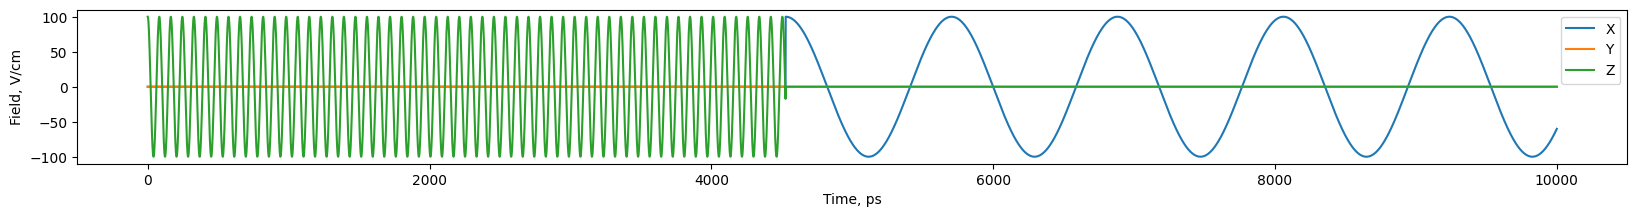

In [8]:
# field, in V/cm, as a function of time, in picoseconds
field = lambda time: field_strength * (
    np.array([0, 0, np.cos(field_frequency_1_2 * 1e-6 * time * 2 * np.pi)])
    if time <= field_duration_1
    else (
        np.array([np.cos(field_frequency_2_3 * 1e-6 * (time - field_duration_1) * 2 * np.pi), 0, 0])
        if time <= field_duration_1 + field_duration_2
        else np.array([0, 0, 0])
    )
)

time = np.linspace(0, 10000, 10000)
plt.figure(figsize=(20, 2))
plt.plot(time, np.array([field(t) for t in time]), label=["X", "Y", "Z"])
plt.xlabel("Time, ps")
plt.ylabel("Field, V/cm")
plt.legend()
plt.show()

### Propagate

Solve the time-dependent Schrödinger equation.

We write the time-dependent wavepacket $\psi(t)$ as a linear combination of the field-free rotational states, $\phi_{J,k_a,k_c,m}=\sum_{k_a,k_c}c_{k_a,k_c}^{(J,m)}|J,k_a,k_c,m\rangle$, as

$$\psi(t) = \sum_{J,k_a,k_c,m} c_{J,k_a,k_c,m}(t) \phi_{J,k_a,k_c,m}$$

The time-dependent Schrödinger equation for the time-dependent coefficients become:

$$i\hbar \frac{\partial}{\partial t}c_i(t) = \sum_j\left(\langle i|\hat{H}_0|j\rangle -\sum_{A=X,Y,Z}\langle i|\mu_A|j\rangle F_A(t)\right)c_i(t)$$

where $i$ and $j$ are multi-indices for field-free rotational states' quanta $\{J,k_a,k_c,m\}$,
and $\langle i|\hat{H}_0|j\rangle = E_i\delta_{ij}$.

In [9]:
# convert field-free Hamiltonian from MHz to 1/ps
h0_matrix_invps = h0_matrix * 1e-6

In [10]:
# convert dipole matrix elelements to units cm/(V*ps)
# ... when we multiply it with field in V/cm, the final units will be 1/ps
dipole_matrix_invps_R = dipole_matrix_R * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS

# solve TDSE for R-1,2-propanediol

coefs_R = np.zeros(h0_matrix.shape[0])
coefs_R[0] = 1.0

coefs_time_R = propagate(
    start_time=0.0,
    end_time=100000,
    time_step=1,
    field=field,
    field_free_matrix=h0_matrix_invps,
    dipole_matrix=dipole_matrix_invps_R,
    initial_coefs=coefs_R,
    on_update=lambda i, t, c: (  # print populations of states no. 0, 8, 4, and 6 at each 1000th timestep
        print(
            t,
            np.abs(c[0]) ** 2,
            np.abs(c[8]) ** 2,
            np.abs(c[4]) ** 2,
            np.abs(c[6]) ** 2,
        )
        if i % 1000 == 0
        else None
    ),
)

0.0 0.9999998272646539 1.2039049335335747e-07 0.0 0.0
1000.010000100001 0.9696548155872522 0.030012303672940475 0.0 0.0
2000.020000200002 0.8838481912429458 0.11514782023556565 0.0 0.0
3000.030000300003 0.7503430495210152 0.24826949954157132 0.0 0.0
4000.040000400004 0.5909203544868628 0.407941791546684 0.0 0.0
5000.050000500005 0.5003719456288154 0.49922465098544505 3.424073116666118e-05 2.9308163742791808e-05
6000.060000600006 0.5003819173504647 0.4984032669027066 0.0005130880566996422 0.0003821995633719634
7000.070000700007 0.5003860746377897 0.4966256200318084 0.0013753252637057614 0.001278124654493777
8000.080000800008 0.5003406293696356 0.494594631222673 0.002650180262007383 0.002075731674091687
9000.090000900009 0.5003803097551619 0.4914315433081073 0.004072289334403553 0.0038019503628948428
10000.10000100001 0.5003679253619768 0.48688396863710953 0.006478646084174329 0.005951754250157825
11000.11000110001 0.5003576823308661 0.4825705595180363 0.008408978763896952 0.008330129982

In [11]:
# convert dipole matrix elelements to units cm/(V*ps)
# ... when we multiply it with field in V/cm, the final units will be 1/ps
dipole_matrix_invps_S = dipole_matrix_S * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS

# solve TDSE for S-1,2-propanediol

coefs_S = np.zeros(h0_matrix.shape[0])
coefs_S[0] = 1.0

coefs_time_S = propagate(
    start_time=0.0,
    end_time=100000,
    time_step=1,
    field=field,
    field_free_matrix=h0_matrix_invps,
    dipole_matrix=dipole_matrix_invps_S,
    initial_coefs=coefs_S,
    on_update=lambda i, t, c: (  # print populations of states no. 0, 8, 4, and 6 at each 1000th timestep
        print(
            t,
            np.abs(c[0]) ** 2,
            np.abs(c[8]) ** 2,
            np.abs(c[4]) ** 2,
            np.abs(c[6]) ** 2,
        )
        if i % 1000 == 0
        else None
    ),
)

0.0 0.9999998272646539 1.2039049335335747e-07 0.0 0.0
1000.010000100001 0.9696548155872522 0.030012303672940475 0.0 0.0
2000.020000200002 0.8838481912429458 0.11514782023556565 0.0 0.0
3000.030000300003 0.7503430495210152 0.24826949954157132 0.0 0.0
4000.040000400004 0.5909203544868629 0.407941791546684 0.0 0.0
5000.050000500005 0.5003719456288098 0.49922465098544505 2.930816374279175e-05 3.424073116666153e-05
6000.060000600006 0.5003819173504559 0.4984032669027066 0.0003821995633719657 0.0005130880566996417
7000.070000700007 0.5003860746377795 0.4966256200318084 0.0012781246544937858 0.0013753252637057607
8000.080000800008 0.5003406293696206 0.494594631222673 0.0020757316740917025 0.0026501802620073783
9000.090000900009 0.5003803097551422 0.4914315433081073 0.0038019503628948744 0.004072289334403535
10000.10000100001 0.5003679253619565 0.48688396863710953 0.005951754250157879 0.006478646084174237
11000.11000110001 0.5003576823308403 0.48257055951803646 0.008330129982313741 0.008408978

### Plot populations of states

Notice, the populations of states for both enantiomers must be exactly the same

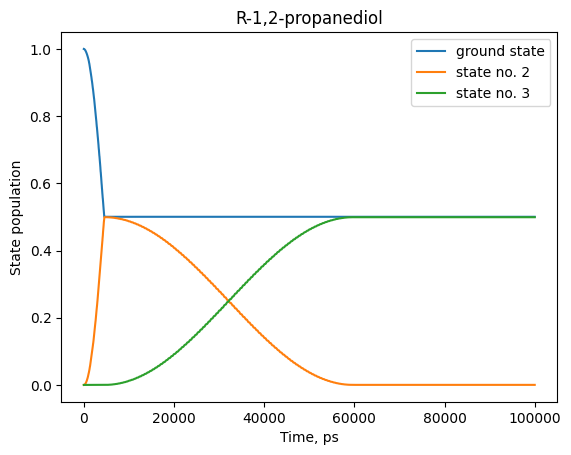

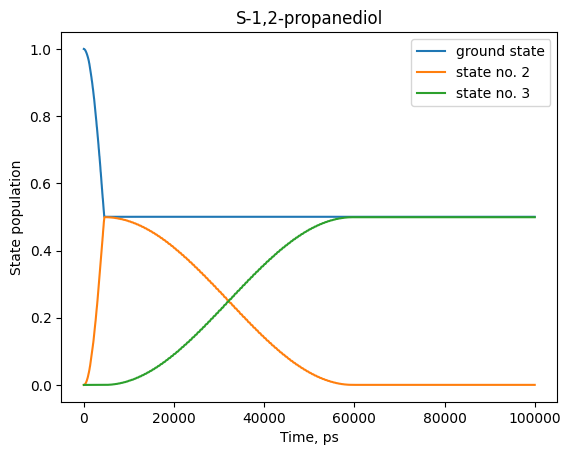

In [12]:
# extract time grid
time_list = np.array([time for (ind, time, coef) in coefs_time_R])

# extract populations for both enantiomers
populations_time_R = np.array([np.abs(coef) ** 2 for (ind, time, coef) in coefs_time_R])
populations_time_S = np.array([np.abs(coef) ** 2 for (ind, time, coef) in coefs_time_S])

# plot populations for R-1,2-propanediol
plt.plot(time_list, populations_time_R[:, 0], label="ground state")
plt.plot(time_list, populations_time_R[:, 8], label="state no. 2")
plt.plot(
    time_list, populations_time_R[:, 4] + populations_time_R[:, 6], label="state no. 3"
)
plt.title("R-1,2-propanediol")
plt.xlabel("Time, ps")
plt.ylabel("State population")
plt.legend()
plt.show()

# plot populations for S-1,2-propanediol
plt.plot(time_list, populations_time_S[:, 0], label="ground state")
plt.plot(time_list, populations_time_S[:, 8], label="state no. 2")
plt.plot(
    time_list, populations_time_S[:, 4] + populations_time_S[:, 6], label="state no. 3"
)
plt.title("S-1,2-propanediol")
plt.xlabel("Time, ps")
plt.ylabel("State population")
plt.legend()
plt.show()

### Plot expectation values of dipole moments

... but the time-evolution of the dipole moment's $Y$ component (because external fields couple other two $Z$ and $X$ components) must have opposite phase for two enantiomers

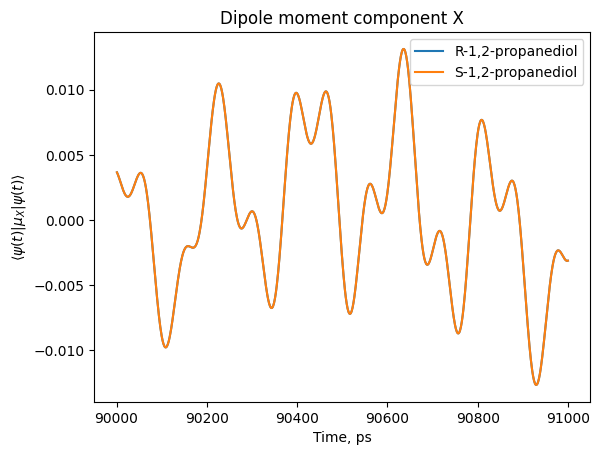

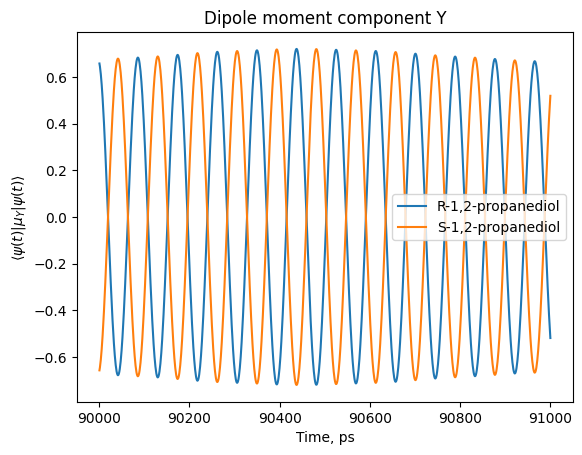

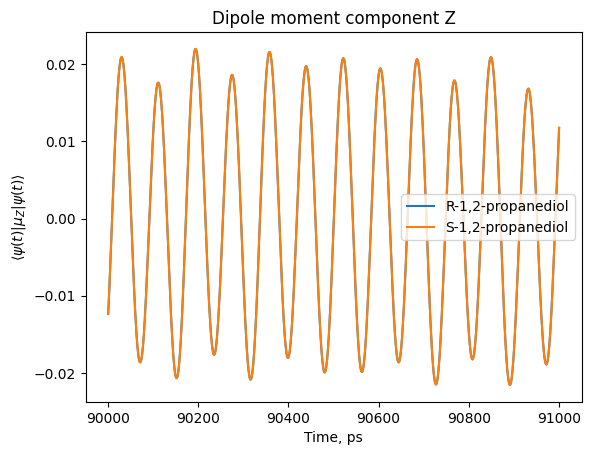

In [13]:
# set time limits to 'zoom in'
time_min = 90000
time_max = 91000

# extract time grid
time_list = np.array(
    [time for (ind, time, coef) in coefs_time_R if time > time_min and time < time_max]
)

# extract coefficients for R-1,2-propanediol
c_time_R = np.array(
    [coef for (ind, time, coef) in coefs_time_R if time > time_min and time < time_max]
)

# extract coefficients for S-1,2-propanediol
c_time_S = np.array(
    [coef for (ind, time, coef) in coefs_time_S if time > time_min and time < time_max]
)

# compute expectation values of dipole moment for R-1,2-propanediol
dipole_expval_R = np.einsum(
    "ti,aij,tj->ta", np.conj(c_time_R), dipole_matrix_R, c_time_R, optimize='optimal'
)

# compute expectation values of dipole moment for S-1,2-propanediol
dipole_expval_S = np.einsum(
    "ti,aij,tj->ta", np.conj(c_time_S), dipole_matrix_S, c_time_S, optimize='optimal'
)

# plot expectation values for X, Y, and Z projections of dipole moment
for icart, cart in enumerate(('X', 'Y', 'Z')):
    plt.plot(time_list, np.real(dipole_expval_R[:, icart]), label='R-1,2-propanediol')
    plt.plot(time_list, np.real(dipole_expval_S[:, icart]), label='S-1,2-propanediol')
    plt.title(f"Dipole moment component {cart}")
    plt.xlabel("Time, ps")
    plt.ylabel(f"$\\langle \\psi(t)|\\mu_{cart}| \\psi(t)\\rangle$")
    plt.legend()
    plt.show()